In [10]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

  
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O ../data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-09-26 12:06:42--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.27.208, 142.250.67.176, 172.217.166.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.27.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘../data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

../data/inception_v 100%[===================>]  83.84M  1.35MB/s    in 66s     

2020-09-26 12:07:50 (1.26 MB/s) - ‘../data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [11]:

local_weights_file = '../data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for l in pre_trained_model.layers:
    l.trainable = False


pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [12]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [24]:
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
flatten_layer = tf.keras.layers.Flatten()(last_output)

In [18]:
dense = tf.keras.layers.Dense(units=1024,activation='relu')(flatten_layer)

In [20]:
drop = tf.keras.layers.Dropout(0.2)(dense)

In [21]:
output = tf.keras.layers.Dense(1,activation='sigmoid')(drop)

In [22]:
model = Model(pre_trained_model.input,output)

In [23]:
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [30]:


# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
                              )
validate_datagen = ImageDataGenerator(rescale=1/255)


# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '../data/cats_and_dogs_filtered/train/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 300x300
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validate_generator = train_datagen.flow_from_directory(
        '../data/cats_and_dogs_filtered/validation/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 300x300
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
history = model.fit(
            train_generator,
            validation_data = validate_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50)

Epoch 1/20
100/100 [==============================] - 101s 1s/step - loss: 0.3528 - accuracy: 0.8580 - val_loss: 0.1568 - val_accuracy: 0.9260
Epoch 2/20
100/100 [==============================] - 119s 1s/step - loss: 0.2201 - accuracy: 0.9125 - val_loss: 0.2185 - val_accuracy: 0.9180
Epoch 3/20
100/100 [==============================] - 106s 1s/step - loss: 0.1944 - accuracy: 0.9250 - val_loss: 0.2004 - val_accuracy: 0.9270
Epoch 4/20
100/100 [==============================] - 106s 1s/step - loss: 0.2056 - accuracy: 0.9260 - val_loss: 0.2061 - val_accuracy: 0.9310
Epoch 5/20
100/100 [==============================] - 109s 1s/step - loss: 0.1949 - accuracy: 0.9315 - val_loss: 0.1951 - val_accuracy: 0.9280
Epoch 6/20
100/100 [==============================] - 107s 1s/step - loss: 0.1712 - accuracy: 0.9325 - val_loss: 0.2113 - val_accuracy: 0.9310
Epoch 7/20
100/100 [==============================] - 104s 1s/step - loss: 0.1357 - accuracy: 0.9455 - val_loss: 0.2226 - val_accuracy: 0.9380

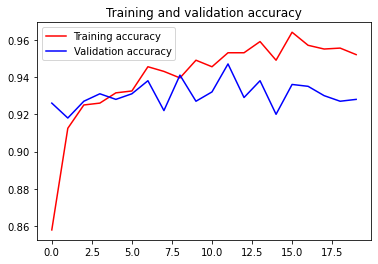

<Figure size 432x288 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()